# Lab 1

这是"深度学习与计算物理"的第一次实验(9.2,2025),分为**Demo**和**Free Exploration**两个部分 \
在**Demo**部分，主要是实现用神经网络拟合函数sin(x)的流程，需要自己配置环境并跑通代码 \
在**Free Exploration**部分，有以下任务：
- 在(0,π)之外的区域预测结果如何，需要如何改进才能预测准
- 如何改进训练集，用不同**batch**而非full batch
- 如何调用不同**优化器(optimizer)**，设置学习率变化(**scheduler**)
- 如何调用一般形式的神经网络，以及损失函数
- 如何拟合二维函数或更高维函数？


## Demo

**Demo**由以下部分组成：
- 导入库
- 定义神经网络
- 定义目标函数和损失函数
- 生成训练数据
- 初始化网络和优化器
- 循环训练
- 测试与可视化


重点讲解一下神经网络的定义：\
Net 继承自 nn.Module，是一个神经网络类。

- __init__()初始化网络：fc1：输入 1 个数，输出 128 个特征。fc2：128 个特征，输出 1 个数。

- forward()前向传播：输入x先经过fc1，然后用 tanh 激活函数（非线性）,再经过 fc2 输出结果。\
所以网络结构是 1 → 128 → 1，用 tanh 增加非线性拟合能力。



在训练过程中，关键步骤：
- 计算loss：`loss = loss_fn(net, x)`
- 清空grad：`optimizer.zero_grad()`
- 反向传播: `loss.backward()`
- 更新参数：`optimizer.step() `

epoch 1000 MSE loss = 0.000342

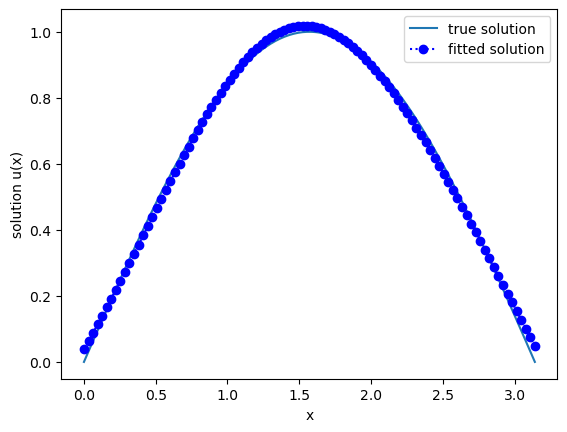

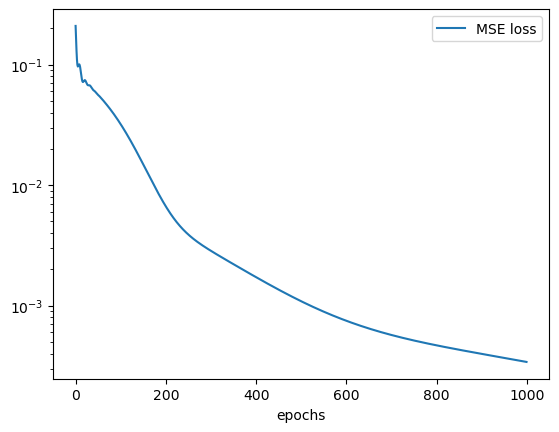

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
from numpy import pi

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # 调用父类 nn.Module 的初始化函数
        self.fc1 = nn.Linear(1,128) # Linear ：全连接层（也叫 Dense 层）。
                                    # 输入 1 个数 ， 经过 fc1 ，输出 128 个数字特征
        self.fc2 = nn.Linear(128,1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

def u(x):
    y = torch.sin(x)
    return y

def loss_fn(net, x_data):
    return (net(x_data) - u(x_data)).pow(2).mean() 

#训练
epochs = 1000
learning_rate = 1e-3
x_test = torch.linspace(0,pi,64).unsqueeze(1) 
net = Net()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_history = []

for i in range(epochs):
    x = x_train                      # full batch
    loss = loss_fn(net, x)           # 计算loss
    loss_history.append(loss.item()) # 记录loss值
    optimizer.zero_grad()            # 清空梯度
    loss.backward()                  # 反向传播
    optimizer.step()                 # 更新参数
    
    print('\repoch {:d} MSE loss = {:.6f}'.format(i+1,loss.item()), end='', flush=True)

#测试
#x_test = torch.unsqueeze(torch.linspace(0,pi,100),dim=1)
x_test = torch.linspace(0,pi,100).unsqueeze(1)
y_test = u(x_test)
y_predict = net(x_test)

plt.figure(1)
plt.plot(x_test, y_test, label='true solution')
plt.plot(x_test, y_predict.detach(), 'bo:', label='fitted solution')
plt.xlabel('x')
plt.ylabel('solution u(x)')
plt.legend()
plt.show()


plt.figure(2)
plt.plot(loss_history,label='MSE loss')
plt.xlabel('epochs')
plt.yscale("log")
plt.legend()
plt.show()

## Problem 1

在(0,π)之外的区域预测结果如何，需要如何改进才能预测准?

## Solution 

在**Demo**中，x_train的范围为(0,pi),当我们把范围修改为(0,2*pi)时，预测肯定是不准的,这是因为(pi,2*pi)上的数据是神经网络Net从未见过的，训练数据与测试数据并未服从相同分布($i.i.d $). \
**解决办法**就是将x_train的数据范围修改为(0,2*pi),使得x_train和x_test数据分布相同

In [22]:
x_test = torch.linspace(0,2 * pi,100).unsqueeze(1)
y_test = u(x_test)
y_predict = net(x_test)

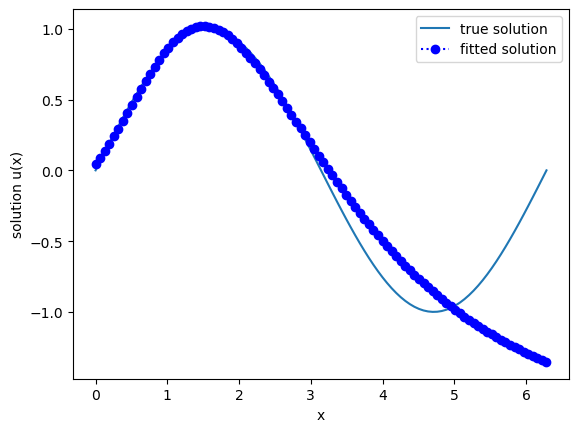

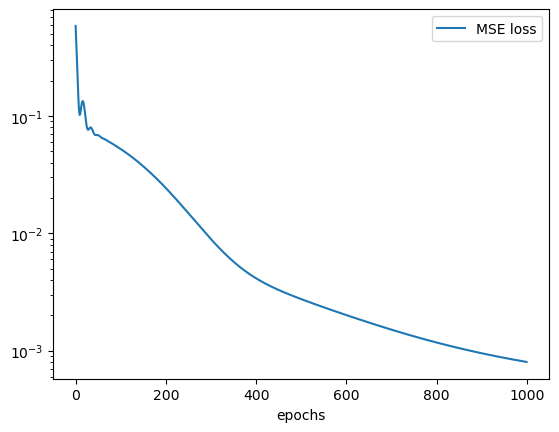

In [23]:
plt.figure(1)
plt.plot(x_test, y_test, label='true solution')
plt.plot(x_test, y_predict.detach(), 'bo:', label='fitted solution')
plt.xlabel('x')
plt.ylabel('solution u(x)')
plt.legend()
plt.show()


plt.figure(2)
plt.plot(loss_history,label='MSE loss')
plt.xlabel('epochs')
plt.yscale("log")
plt.legend()
plt.show()

In [33]:
# train agian

#训练
epochs = 1000
learning_rate = 1e-3
x_train = torch.linspace(0,2*pi,200).unsqueeze(1)
net = Net()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_history = []

for i in range(epochs):
    x = x_train        #full batch
    loss = loss_fn(net,x)
    loss_history.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('\repoch {:d} MSE loss = {:.6f}'.format(i+1,loss.item()), end='', flush=True)

epoch 1000 MSE loss = 0.029890

In [34]:
x_test = torch.linspace(0,2*pi,100).unsqueeze(1)
y_test = u(x_test)
y_predict = net(x_test)

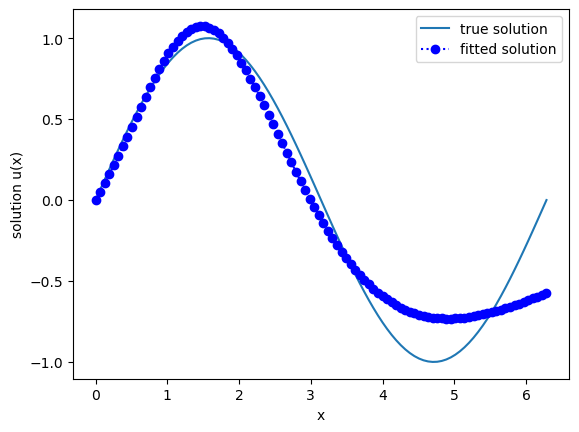

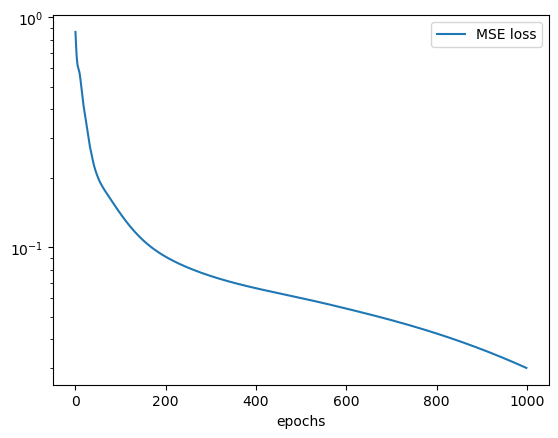

In [35]:
plt.figure(1)
plt.plot(x_test, y_test, label='true solution')
plt.plot(x_test, y_predict.detach(), 'bo:', label='fitted solution')
plt.xlabel('x')
plt.ylabel('solution u(x)')
plt.legend()
plt.show()


plt.figure(2)
plt.plot(loss_history,label='MSE loss')
plt.xlabel('epochs')
plt.yscale("log")
plt.legend()
plt.show()

## problem 2
如何改进训练集，用不同batch而非full batch?

## solution 2

这里是mini-batch和full-batch的对比：
- full-batch 梯度稳定，但是参数更新慢
- mini-batch 梯度噪声大，有助于跳出局部最优点

可以使用`torch.utils.data.DataLoader`: 

``
from torch.utils.data import TensorDataset, DataLoader 
``
\
``
dataset = TensorDataset(x_train,y) 
``
\
``
loader = DataLoader(dataset, batch_size=16, shuffle=True) 
``

从结果可以见到，使用full-batch的loss最小值在$ 10^{-1} $附近，使用mini-batch的loss最小值在$ 10^{-5} $附近，这表明mini-batch有助于跳出局部最优点

In [46]:
# use batch
from torch.utils.data import DataLoader, TensorDataset

In [36]:
epochs = 1000
learning_rate = 1e-3
batch_size = 16

x_train = torch.linspace(0,2*pi,200).unsqueeze(1)
dataset = TensorDataset(x_train, u(x_train)) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # 每次迭代返回一个 batch

In [82]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_history = []

In [40]:
# mini-batch
for i in range(epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in dataloader:
        loss = loss_fn(net, x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.shape[0]
    
    avg_epoch_loss = epoch_loss / len(dataset)
    loss_history.append(avg_epoch_loss)
    print('\repoch {:d} MSE loss = {:.6f}'.format(i+1, avg_epoch_loss), end='', flush=True)

epoch 1000 MSE loss = 0.000200

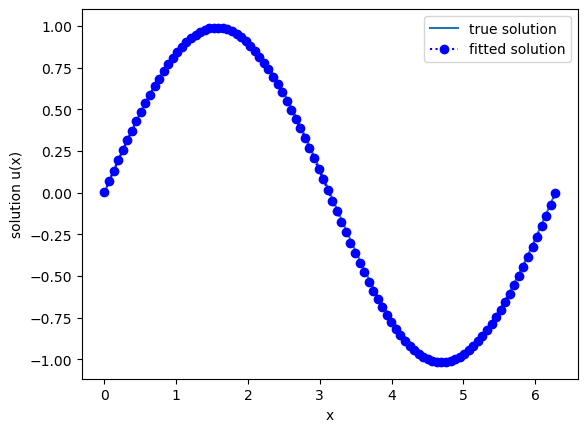

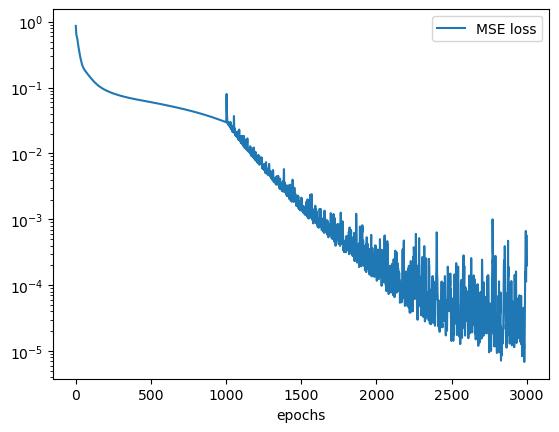

In [41]:
x_test = torch.linspace(0,2*pi,100).unsqueeze(1)
y_test = u(x_test)
y_predict = net(x_test)
plt.figure(1)
plt.plot(x_test, y_test, label='true solution')
plt.plot(x_test, y_predict.detach(), 'bo:', label='fitted solution')
plt.xlabel('x')
plt.ylabel('solution u(x)')
plt.legend()
plt.show()
plt.figure(2)
plt.plot(loss_history,label='MSE loss')
plt.xlabel('epochs')
plt.yscale("log")
plt.legend()
plt.show()

## problem 3
如何调用不同优化器，设置学习率变化

## solution 3
了解**优化器选择**和**动态学习率调节**:
- 不同优化器对训练速度和收敛影响很大（SGD, Adam, RMSprop, Adagrad…）
- 学习率调度器 (scheduler) 可以让学习率随训练逐渐减小，提高收敛精度


``
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
``
\
``
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
``
\
``
for epoch in range(epochs):
``
\
``
    # 训练代码
``
\
``
    scheduler.step()
``

In [101]:
# load
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, ExponentialLR

epochs = 1000
learning_rate = 1e-3
batch_size = 16

x_train = torch.unsqueeze(torch.linspace(pi,2 * pi,100),dim=1) 
dataset = TensorDataset(x_train, u(x_train)) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # 每次迭代返回一个 batch
net = Net()

#optimizer = optim.SGD(net.parameters(), lr=learning_rate)            # SGD
optimizer = optim.Adam(net.parameters(), lr=learning_rate)           # Adam
#optimizer = optim.AdamW(net.parameters(), lr=learning_rate)          # AdamW
#optimizer = optim.RMSprop(net.parameters(), lr=learning_rate)        # RMSprop
#optimizer = optim.Adagrad(net.parameters(), lr=learning_rate)         # Adagrad

#scheduler = StepLR(optimizer, step_size=100, gamma=0.5)              # 每100轮学习率 ×0.5
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10)         # 当 loss 不下降时降低学习率
#scheduler = ExponentialLR(optimizer, gamma=0.99)                      # 每轮学习率 ×0.99

loss_history = []

#  mini-batch
for i in range(epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in dataloader:
        loss = loss_fn(net, x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x_batch.shape[0]

    avg_epoch_loss = epoch_loss / len(dataset)
    loss_history.append(avg_epoch_loss)
    #scheduler.step() # update lr  // 
    scheduler.step(avg_epoch_loss)
    
    print('\repoch {:d} MSE loss = {:.6f}'.format(i+1, avg_epoch_loss), end='', flush=True)

epoch 1000 MSE loss = 0.005207

# problem 4
如何调用一般形式的神经网络，以及损失函数

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from numpy import pi

# general train fuction
def train_model(
    model,
    dataloader,
    loss_fn,
    optimizer,
    scheduler=None,
    epochs=1000,
    device='cpu'
):
    """
    general train function
    
    param：
    - model: nn
    - dataloader: data loader
    - loss_fn: loss function（param: model , batch ）
    - optimizer: optimizer
    - scheduler: learning rate scheduler（optional）
    - epochs: training epochs
    - device: 'cpu' or 'cuda'
    """
    model.to(device)
    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        model.train()  # set to training model

        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # forward
            loss = loss_fn(model, x_batch, y_batch)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * x_batch.shape[0]

        avg_loss = epoch_loss / len(dataloader.dataset)
        loss_history.append(avg_loss)

        # update lr
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_loss)
            else:
                scheduler.step()

        print(f'\repoch {epoch+1} loss = {avg_loss:.6f}', end='', flush=True)

    return loss_history

# general net class
class GeneralNet(nn.Module):
    def __init__(self, input_dim=1, hidden_layers=[128], output_dim=1, activation='tanh'):
        """
        general nn structure
        
        param：
        - input_dim: input dim
        - hidden_layers: e.g. [128, 64, 32]
        - output_dim: output dim
        - activation: active function types
        """
        super(GeneralNet, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # set hidden layers
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            if activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            prev_dim = hidden_dim
            
        # output
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


def general_loss_fn(model, x, y_true, loss_type='mse'):
    """
    loss fn
    
    param：
    - model: model
    - x: input
    - y_true: true label
    - loss_type: loss function type
    """
    y_pred = model(x)
    
    if loss_type == 'mse':
        return nn.functional.mse_loss(y_pred, y_true)
    elif loss_type == 'mae':
        return nn.functional.l1_loss(y_pred, y_true)
    elif loss_type == 'smooth_l1':
        return nn.functional.smooth_l1_loss(y_pred, y_true)
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}")

if __name__ == "__main__":
    # 1. define model
    net = GeneralNet(input_dim=1, hidden_layers=[128, 128,128], output_dim=1, activation='relu')

    # 2. define y = f(x)
    def u(x):
        return torch.sin(x)

    # 3. prepare data
    x_train = torch.unsqueeze(torch.linspace(0, pi, 64), dim=1)
    dataset = TensorDataset(x_train, u(x_train))
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # 4. define optimizer and scheduler
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

    # 5. loss
    loss_history = train_model(
        model=net,
        dataloader=dataloader,
        loss_fn=lambda model, x, y: general_loss_fn(model, x, y, 'mse'),
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=1000
    )

    print("\nTraining completed!")

epoch 1000 loss = 0.000000
Training completed!


# problem 5
如何拟合二维函数或更高维函数？


# solution 5
使用前面类似的方法，拟合一个二维函数，并在后面给出loss图像以及拟合函数可视化图

f(u,v)=u^2+3uv+v^3

Epoch [500/5000], Loss: 0.4278
Epoch [1000/5000], Loss: 0.1774
Epoch [1500/5000], Loss: 0.1397
Epoch [2000/5000], Loss: 0.1290
Epoch [2500/5000], Loss: 2.3179
Epoch [3000/5000], Loss: 0.1778
Epoch [3500/5000], Loss: 0.0946
Epoch [4000/5000], Loss: 0.0840
Epoch [4500/5000], Loss: 0.0787
Epoch [5000/5000], Loss: 0.0738


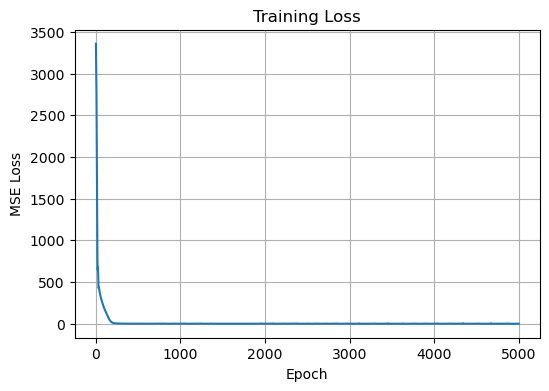

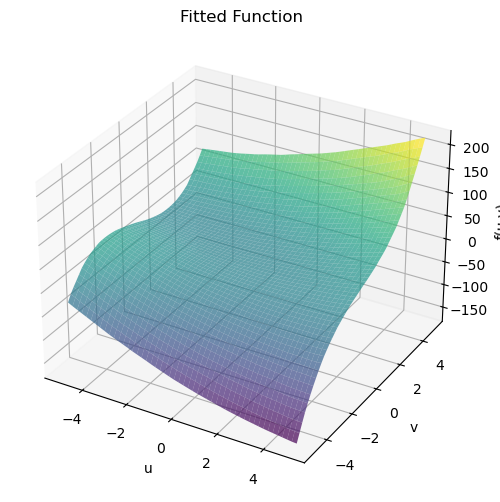

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. 生成训练数据
np.random.seed(0)
torch.manual_seed(0)

# 随机生成u,v
N = 1000
u = np.random.uniform(-5, 5, N)
v = np.random.uniform(-5, 5, N)

# 真实函数值
y = u**2 + 3*u*v + v**3

# 转为 PyTorch 张量
u_tensor = torch.tensor(u, dtype=torch.float32).unsqueeze(1)
v_tensor = torch.tensor(v, dtype=torch.float32).unsqueeze(1)
X = torch.cat([u_tensor, v_tensor], dim=1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# 2. 定义简单的神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

# 3. 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 4. 训练模型
num_epochs = 5000
loss_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. 绘制loss曲线
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# 6. 可视化拟合函数
u_test = np.linspace(-5,5,50)
v_test = np.linspace(-5,5,50)
U, V = np.meshgrid(u_test, v_test)
UV_tensor = torch.tensor(np.stack([U.ravel(), V.ravel()], axis=1), dtype=torch.float32)
Y_pred = model(UV_tensor).detach().numpy().reshape(U.shape)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(U, V, Y_pred, cmap='viridis', alpha=0.7)
ax.set_xlabel('u')
ax.set_ylabel('v')
ax.set_zlabel('f(u,v)')
ax.set_title('Fitted Function')
plt.show()


再次拟合$ f(x,y)=sin(x)+cos(y)^2+5xy+3x^4+tan(x^5) $

Using device: cpu
epoch 1500 loss = 0.000015
Total training time: 126.03 seconds


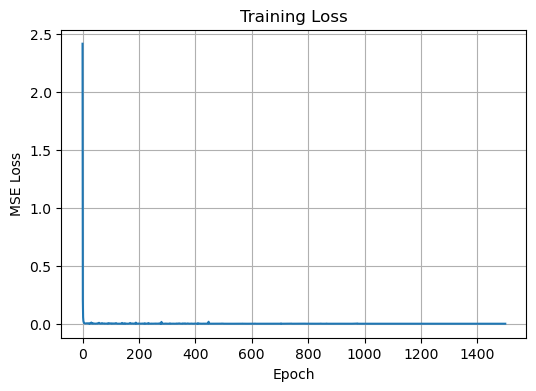

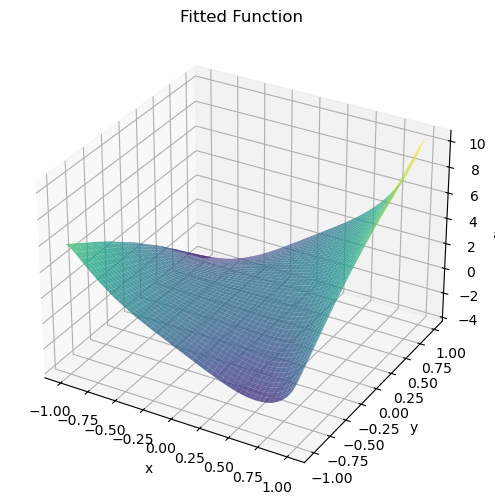

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

# -----------------------------
# 1. 定义函数
# -----------------------------
def f(x, y):
    return torch.sin(x) + torch.cos(y)**2 + 5*x*y + 3*x**4 + torch.tan(x**5)

# -----------------------------
# 2. 生成训练数据
# -----------------------------
N = 2000
x = torch.rand(N, 1) * 2 - 1   # [-1, 1]
y = torch.rand(N, 1) * 2 - 1   # [-1, 1]
X = torch.cat([x, y], dim=1)
y_true = f(x, y)

dataset = TensorDataset(X, y_true)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# -----------------------------
# 3. 设置设备
# -----------------------------
device = torch.device("cpu") # "cuda" or "cpu"
print(f"Using device: {device}")

# -----------------------------
# 4. 定义模型
# -----------------------------
net = GeneralNet(input_dim=2, hidden_layers=[256, 256, 256], output_dim=1, activation='relu')
net.to(device)  # 将模型移动到GPU

# -----------------------------
# 5. 定义优化器和scheduler
# -----------------------------
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

# -----------------------------
# 6. 训练
# -----------------------------
start_time = time.time()  # 记录开始时间

loss_history = train_model(
    model=net,
    dataloader=dataloader,
    loss_fn=lambda model, x, y: general_loss_fn(model, x, y, 'mse'),
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=1500,
    device=device
)

end_time = time.time()  # 记录结束时间
total_time = end_time - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

# -----------------------------
# 7. 绘制loss曲线
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# -----------------------------
# 8. 可视化拟合函数
# -----------------------------
grid_points = 50
x_test = torch.linspace(-1, 1, grid_points)
y_test = torch.linspace(-1, 1, grid_points)
X_grid, Y_grid = torch.meshgrid(x_test, y_test)
XY_test = torch.cat([X_grid.reshape(-1,1), Y_grid.reshape(-1,1)], dim=1).to(device)

with torch.no_grad():
    Z_pred = net(XY_test).cpu().numpy().reshape(X_grid.shape)  # 输出转回CPU

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_grid.numpy(), Y_grid.numpy(), Z_pred, cmap='viridis', alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.set_title('Fitted Function')
plt.show()
